In [5]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline



bedgraph files are here: 

/projects/seqdev/DA-77/new_pipeline_control/step2

/projects/seqdev/DA-77/new_pipeline/step2

/projects/seqdev/DA-77/new_pipeline_treatment/step2

MCS2 output:
    
https://github.com/taoliu/MACS/

questions for Misha:
repressive marks: H3K9me3 and H3K27me3, 
broad marks: H3K4me1, H3K9me3, H3K27me3, H3K36me3
1. for 6 marks: marks = "H3K4me1","H3K4me3","H3K9me3","H3K27me3","H3K36me3","H3K27ac", what regions am i supposed to look at. for example, for H3K4me3 and H3K4me1 and H3K27ac and H3K27me3(negative mark means gene not expressed), , I can look at putative promoter regions.
H3K9me3(repressive mark ), complex repetative  regions. leave for later, mark for repetative regions and genes important for development, 1 million regions, bin genome to 10kb bins remove 0 values and cluster on the whole genome   
H3K36me3, use gene body. ask file from Misha
H3K4me1 and H3K27ac() can cluster on enhancer and txn binding regions.

2. confirm my workflow are correct:
1) intersect bdg file with hg19v69_genes.TSS_2000.pc.bed
2) sum bdg values for each putative promoters and divide by region length (4000) to get average signal values. i should have integrated on the various bins, (end-start +1)*coverage. see if 0 or 1 based. also Alessia requested using jaccard value, basically i will need a segmenation bed file telling the regions are enriched and then get the jaccard value while overlap enriched regions and putative promoter regions or gene body. 
3) cluster 


chromatin states: 100+ histone modifictions
example:
H3K4me3: promoters
H3K4me1: enhancers
H3K9me3: repressive
H3K27me3:repressive
H3K36me3: transcribed


# intersect treatment with TSS+-2kb

In [311]:
# command used to instersect signals in putative promoter regions
# while read i;do /home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a ../hg19v69_genes.TSS_2000.pc.bed -b /projects/seqdev/DA-77/new_pipeline_treatment/step2/$i -wa -wb > $i.intersected;done < ../all_sorted_treat_pileup_bdg_files_names.txt


In [96]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'

get meta data about library ids, hiv status, histology, total reads sequenced etc

In [97]:
f = '/home/szong/projects/META_2018/Master_Sample_table_14X292_Feb27_2018_sz.xls'
meta = pd.read_excel(f, sheetname='HTMCP CaCx epi')
meta.head(2)

,Order,Biospecimen ID,HIV status,Epigenome modifier mutation status,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,...,H3K4me3 % aligned,H3K9me3 % aligned,H3K27me3 % aligned,H3K36me3 % aligned,H3K27ac % aligned,input DNA control % aligned,internal sample ID,pool ID,Notes,# lanes 7 PE
0,1,HTMCP-03-06-02007-01A,negative,mutated,A84624,A84625,A84626,A84627,A84628,A84629,...,98.13,93.1,97.93,98.57,98.10,96.26,NaN,IX5978,NaN,1
1,2,HTMCP-03-06-02026-01A,negative,mutated,A84645,A84646,A84647,A84648,A84649,A84650,...,97.68,93.89,97.84,98.17,97.86,95.56,NaN,IX5981,NaN,1


In [98]:
meta = meta[['Biospecimen ID', 'H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID',
       'input DNA control  library ID',  'H3K4me1 total reads', 'H3K4me3  total reads',
       'H3K9me3 total reads', 'H3K27me3 total reads', 'H3K36me3 total reads',
       'H3K27ac total reads', 'input DNA control  total reads']].dropna()

In [99]:
meta.head(2)

,Biospecimen ID,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads
0,HTMCP-03-06-02007-01A,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0
1,HTMCP-03-06-02026-01A,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0


In [100]:
meta['patient'] = meta['Biospecimen ID'].apply(lambda x: '-'.join(['HTMCP-03-06', x.split('-')[3]]))

In [101]:
meta = meta.drop('Biospecimen ID', axis=1)

In [102]:
meta.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026


In [103]:
# add in hiv status and histology
f22 ='/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/mutation_load_clinic.txt'
df22 = pd.read_csv(f22, sep='\t')
df22 = df22[['patient', 'HIV_status', 'Putative_histology', 'strelka_mutations', 'HPV_status']]
# df22 = df22.set_index('patient')#.stack().reset_index()
df22.head(2)

,patient,HIV_status,Putative_histology,strelka_mutations,HPV_status
0,HTMCP-03-06-02001,Positive,Squamous,26974,Positive
1,HTMCP-03-06-02002,Negative,Squamous,16661,Positive


In [104]:
df_meta = pd.merge(meta, df22, left_on='patient', right_on='patient')
df_meta.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient,HIV_status,Putative_histology,strelka_mutations,HPV_status
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007,Negative,Adeno,2958282,Negative
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026,Negative,Adeno,1252217,Negative


In [105]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/chipseq_meta.txt'
# df_meta.to_csv(of, sep='\t', index=False)

In [106]:
category_track = df_meta[['patient', 'HIV_status', 'Putative_histology', 'HPV_status']]
numeric_track = df_meta[['patient', 'strelka_mutations', ]]

In [107]:
category_track.head(2)

,patient,HIV_status,Putative_histology,HPV_status
0,HTMCP-03-06-02007,Negative,Adeno,Negative
1,HTMCP-03-06-02026,Negative,Adeno,Negative


In [108]:
numeric_track.head(2)


,patient,strelka_mutations
0,HTMCP-03-06-02007,2958282
1,HTMCP-03-06-02026,1252217


In [109]:
numeric_track['log_strelka_mutations'] = np.log10(numeric_track['strelka_mutations'])

/home/szong/anaconda3/envs/szvenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [110]:
numeric_track = numeric_track.drop('strelka_mutations', axis=1)

In [111]:
numeric_track.head(2)

,patient,log_strelka_mutations
0,HTMCP-03-06-02007,6.47104
1,HTMCP-03-06-02026,6.09768


read in Alessia's epigenetic gene categorization file

In [112]:
f4 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/categorisation_of_epigentic_modifiers_from_Alessia_v3.xls'
df4 = pd.read_excel(f4, sheetname='categorisation')
df4.head(2)

,HIV neg,neg samples with mutations,HIV positive,pos samples with mutation,total,Category_1,Category_2,markes /regiones affected,comments
0,MLL3,9,MLL3,6,15,Writer,compass complex,H3k4me1,NaN
1,MLL2,7,MLL2,5,12,Writer,compass complex,H3K4me3,NaN


In [113]:
df4[df4.Category_2 == 'HDAC complex']

,HIV neg,neg samples with mutations,HIV positive,pos samples with mutation,total,Category_1,Category_2,markes /regiones affected,comments
39,HDAC4,0,HDAC4,3,3,Eraser,HDAC complex,H3K27ac,NaN
40,HDAC6,1,HDAC6,2,3,Eraser,HDAC complex,H3K27ac,NaN
41,HDAC9,3,HDAC9,0,3,Eraser,HDAC complex,H3K27ac,NaN
61,HDAC7,0,HDAC7,2,2,Eraser,HDAC complex,H3K27ac,NaN
83,HDAC10,1,HDAC10,0,1,Eraser,HDAC complex,H3K27ac,NaN
84,HDAC2,1,HDAC2,0,1,Eraser,HDAC complex,H3K27ac,NaN
86,HDAC5,0,HDAC5,1,1,Eraser,HDAC complex,H3K27ac,NaN


In [114]:
df41 = df4[['HIV neg', 'Category_1', 'Category_2']].set_index('HIV neg')
df41.head(2)

,Category_1,Category_2
HIV neg,,
MLL3,Writer,compass complex
MLL2,Writer,compass complex


In [115]:
df41.Category_1.unique()

array(['Writer', 'Remodeller', 'Eraser', 'Reader', nan], dtype=object)

In [116]:
df41.Category_2.value_counts()

Polycomb complex                                                              10
compass complex                                                                9
INO80/SWR remodelling complexes                                                9
HDAC complex                                                                   7
ISWI remdelling complexes                                                      7
GNAT family HAT complexes                                                      7
MYST family HAT complexes                                                      5
SWI/SNF remodeling complex                                                     5
NuRD complex                                                                   5
SEC (Super Elongation) Complex                                                 4
EP300/CBP HAT complexes                                                        3
TFIID basal transcription factor complex or PCAF histone acetylase complex     3
RNF20/40 complex            

In [117]:
df5 = pd.read_excel(f4, sheetname='sample_mut_details_sz', index_col='patient')
df5.head(2)

,HIV status,ARID1A,ATRX,BAZ1A,BAZ1B,BAZ2B,BRD2,BRD3,BRD4,BRD7,...,TBL1X,TFPT,TRIM33,UBE2B,TRRAP,WHSC1L1,YEATS2,YY1,ZMYND11,ZMYND8
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02007,HIV negative,1,1,1,0,1,0,0,1,1,...,0,0,0,0,1,0,0,1,0,1
HTMCP-03-06-02026,HIV negative,1,1,0,1,1,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0


In [118]:
df51 = df5[df5.columns[1:]].T

df51.head(2)

patient,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02063,HTMCP-03-06-02214,HTMCP-03-06-02042,HTMCP-03-06-02332,HTMCP-03-06-02185,HTMCP-03-06-02012,HTMCP-03-06-02196,HTMCP-03-06-02203,...,HTMCP-03-06-02076,HTMCP-03-06-02113,HTMCP-03-06-02230,HTMCP-03-06-02170,HTMCP-03-06-02152,HTMCP-03-06-02235,HTMCP-03-06-02195,HTMCP-03-06-02261,HTMCP-03-06-02147,HTMCP-03-06-02267
ARID1A,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATRX,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
df6 = pd.merge(df51, df41, left_index=True, right_index=True)

df6.head(2)

,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02063,HTMCP-03-06-02214,HTMCP-03-06-02042,HTMCP-03-06-02332,HTMCP-03-06-02185,HTMCP-03-06-02012,HTMCP-03-06-02196,HTMCP-03-06-02203,...,HTMCP-03-06-02230,HTMCP-03-06-02170,HTMCP-03-06-02152,HTMCP-03-06-02235,HTMCP-03-06-02195,HTMCP-03-06-02261,HTMCP-03-06-02147,HTMCP-03-06-02267,Category_1,Category_2
ARID1A,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Remodeller,SWI/SNF remodeling complex
ATRX,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Remodeller,SWI/SNF family


In [120]:
def categorize_cols(df, col):
    col_values = df[col].unique()
    lst = []
    for col_value in col_values:
        s = df.query('{0} == "{1}"'.format(col, col_value)).sum()
        lst.append(s)
    dfo = pd.DataFrame(lst)
    dfo.index = col_values
    dfo = dfo.drop([col], axis=1)
    return dfo

In [121]:
df8 = categorize_cols(df6, 'Category_1').drop('Category_2', axis=1)

df8.head(2)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02042,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP.03.06.02037,HTMCP.03.06.02046,HTMCP.03.06.02150,HTMCP.03.06.02174
Remodeller,0.0,0.0,2.0,16.0,1.0,1.0,9.0,0.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
Reader,1.0,0.0,0.0,21.0,1.0,1.0,7.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [122]:
df9 = categorize_cols(df6, 'Category_2').drop('Category_1', axis=1)

df9.head(2)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02042,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP.03.06.02037,HTMCP.03.06.02046,HTMCP.03.06.02150,HTMCP.03.06.02174
SWI/SNF remodeling complex,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
SWI/SNF family,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
df10 = pd.concat([df8, df9]).reset_index().dropna().set_index('index').astype(float)

df10.head(2)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02042,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP.03.06.02037,HTMCP.03.06.02046,HTMCP.03.06.02150,HTMCP.03.06.02174
index,,,,,,,,,,,,,,,,,,,,,
Remodeller,0.0,0.0,2.0,16.0,1.0,1.0,9.0,0.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
Reader,1.0,0.0,0.0,21.0,1.0,1.0,7.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [124]:
df10[df10 < 0.5] = np.nan
df10[df10 > 0.5] = 'Positive'
df10.fillna('Negative', inplace=True)

In [125]:
df10.head(2)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02042,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP.03.06.02037,HTMCP.03.06.02046,HTMCP.03.06.02150,HTMCP.03.06.02174
index,,,,,,,,,,,,,,,,,,,,,
Remodeller,Negative,Negative,Positive,Positive,Positive,Positive,Positive,Negative,Positive,Positive,...,Positive,Negative,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative
Reader,Positive,Negative,Negative,Positive,Positive,Positive,Positive,Negative,Negative,Positive,...,Negative,Negative,Negative,Positive,Positive,Positive,Negative,Negative,Negative,Negative


In [126]:
category_track.head(2)

,patient,HIV_status,Putative_histology,HPV_status
0,HTMCP-03-06-02007,Negative,Adeno,Negative
1,HTMCP-03-06-02026,Negative,Adeno,Negative


In [127]:
df11 = df10.T

In [128]:
df11.head(2)

index,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,ISWI remdelling complexes,SEC (Super Elongation) Complex,INO80/SWR remodelling complexes,Testis-specific chromatin protein,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
HTMCP-03-06-02001,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Positive
HTMCP-03-06-02002,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative


In [129]:
category_track = pd.merge(category_track, df11, left_on='patient', right_index=True, how='left')

In [130]:
category_track

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive
2,HTMCP-03-06-02063,Negative,Squamous,Positive,Positive,Positive,Positive,Negative,Negative,Positive,...,Negative,Negative,Negative,Positive,Negative,Negative,Positive,Negative,Negative,Negative
3,HTMCP-03-06-02214,Negative,Squamous,Positive,Positive,Positive,Positive,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative
4,HTMCP-03-06-02042,Negative,Squamous,Positive,Positive,Positive,Positive,Positive,Negative,Negative,...,Negative,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative,Positive
5,HTMCP-03-06-02332,Negative,Squamous,Positive,Positive,Positive,Positive,Negative,Negative,Negative,...,Negative,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative,Negative
6,HTMCP-03-06-02185,Negative,Squamous,Positive,Negative,Positive,Positive,Positive,Negative,Negative,...,Negative,Negative,Negative,Positive,Positive,Positive,Negative,Negative,Negative,Negative
7,HTMCP-03-06-02012,Negative,Squamous,Positive,Positive,Positive,Positive,Negative,Negative,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Negative
8,HTMCP-03-06-02196,Negative,Squamous,Positive,Negative,Positive,Positive,Negative,Negative,Negative,...,Negative,Positive,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Negative
9,HTMCP-03-06-02203,Negative,Adeno,Positive,Negative,Positive,Positive,Positive,Negative,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Negative


process chipseq signals

In [131]:
def get_files(f):
    # f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f,header=None)
    df.columns = ['file']
    df.head(2)
    return df


In [132]:
def integrate_signals(f):
#     f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = ['chr', 'start', 'end', 'gene', 'chip_chr', 'chip_start', 'chip_end', 'peak_height']
    df['area'] = df.peak_height * (df.chip_end - df.chip_start)
    dfg = df.groupby(['chr', 'start', 'end', 'gene'])['area'].sum().reset_index()
    of = '{0}.{1}'.format(f, 'sum')
    dfg.to_csv(of, index=False)

In [133]:
def sum_signals_to_delete(f):
    # f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = ['chr', 'start', 'end', 'gene', 'chip_chr', 'chip_start', 'chip_end', 'peak_height']
    dfg = df.groupby(['chr', 'start', 'end', 'gene'])['peak_height'].sum().reset_index()
    of = '{0}.{1}'.format(f, 'sum')
    dfg.to_csv(of, index=False)


In [59]:

def process_signals(df1):
#     f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/treat_pileup_files.txt' 
    for idx, f in df1.iterrows():
        f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/{}'.format(f['file'])
        integrate_signals(f)

In [134]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/treat_intersected_files.txt'
df1 = get_files(f1)

In [60]:
process_signals(df1)

In [20]:
# # process control, sum signals
# f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/control_files.txt'
# df2 = get_files(f2)
# # process_signals(f2)

In [21]:
# df3 = pd.merge(df1, df2, left_index=True, right_index=True)
# df3.head(2)

,file_x,file_y
0,sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84611_H3K4me3_control_lambda.bdg
1,sorted_UCSC_A84618_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84618_H3K4me3_control_lambda.bdg


In [24]:
def visulize_control_treat_signal():
    # scatter plot to visualize treat vs control signal 
    num_pats = df3.shape[0]
    plt_per_row = 8
    nrow = math.floor(num_pats/plt_per_row)+1

    fig, axes = plt.subplots(nrow, plt_per_row, sharex='col', sharey='row', figsize=(2*plt_per_row, nrow*2))
    for idx, f in df3.iterrows():
        f4 = '{0}{1}.intersected.sum'.format(wkdir, f['file_x'])
        library = f['file_x'].split('_')[2]
        f5 = '{0}{1}.intersected.sum'.format(wkdir, f['file_y'])
        df4 = pd.read_csv(f4).set_index(['chr', 'start', 'end', 'gene'])
        df5 = pd.read_csv(f5).set_index(['chr', 'start', 'end', 'gene'])
        dfm = pd.merge(df4, df5, left_index=True, right_index=True)
    #     print(dfm.head(2))
        axrow = math.floor(idx/plt_per_row)
        axcol = idx%plt_per_row
        ax = axes[axrow, axcol]
        sns.regplot(x = 'peak_height_y', y = 'peak_height_x',fit_reg=False, ax=ax, data = dfm)
        ax.set(xlabel='control', ylabel='treat')
        ax.set(xlim=(0, 200000), ylim=(0, 300000))
        ax.text(50000, 250000, library)
    plt.suptitle('H3K4me3_bdg_sum_control_vs_treat', fontsize=14)  
    plt.tight_layout()
    of = '{}H3K4me3_bdg_sum_control_vs_treat.png'.format(wkdir)
    plt.savefig(of, dpi=200, box_inches='tight')
    plt.show()


In [749]:
pdist?

merge signals from all libraries into matrix

In [135]:
df1.head(2)

,file
0,sorted_UCSC_A84610_H3K4me1_treat_pileup.bdg.in...
1,sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.in...


In [136]:
df1.shape

(210, 1)

In [137]:
print(df1.loc[1,:][0])

sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected


In [138]:
marks = ["H3K4me1",
"H3K4me3",
"H3K9me3",
"H3K27me3",
"H3K36me3",
"H3K27ac"
]

In [139]:
# df1.file.str.contains('H3K4me3')

In [146]:
def merge_data(df):
    dfm = pd.DataFrame()
    for idx, f in df.iterrows():
        f1 = '{0}/{1}/{2}.sum'.format(wkdir, 'pileup_files', f['file'])
#         library = '_'.join(f['file_y'].split('_')[2:5])
        library = f['file'].split('_')[2]
        df1 = pd.read_csv(f1).set_index(['chr', 'start', 'end', 'gene'])
        df1.columns = [library]
        if dfm.empty:
            dfm = df1.copy()
        else:
            dfm = pd.merge(dfm, df1, left_index=True, right_index=True)
    return dfm
 

unsupervised clustering based on mean promoter H3K4me3 signal

heatmap to visualize the data

In [73]:
# cmap = sns.light_palette('red', as_cmap=True)
# g = sns.clustermap(dfm2, cmap = cmap)
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# pass

In [72]:
def make_dendrogram(dfmm2, mark):
#     dfmm2 = dfm.copy()
    np.isnan(dfmm2.values).any()
    np.isinf(dfmm2.values).any()

    # cluster by promoter signals so the array needs to be [number of patients, number of features]
    matrix = dfmm2.values.T
    matrix

    dist='correlation'
    link='ward'
    Z = linkage(pdist(matrix, dist), link)

    fig, ax = plt.subplots(figsize=(12,6))
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfmm2.columns,leaf_font_size=12.,show_contracted=True)#
#     plt.suptitle('unsupervised_clustering_{}_bdg_mean'.format, fontsize=14)  
    plt.title('unsupervised_clustering_{}_bdg_mean'.format, fontsize=14)
    plt.tight_layout()
    of = '{0}unsupervised_clustering_{1}_bdg_mean.png'.format(wkdir, mark)
    plt.savefig(of, dpi=200, box_inches='tight')

In [74]:
# df_track.head()

In [81]:
# def get_track_df(dfm2, df_meta):
#     # get labels of the dendrogram and make track data frame
#     # cluster by promoter signals so the array needs to be [number of patients, number of features]
#     matrix = dfm2.values.T
#     dist='correlation'
#     link='ward'
#     Z = linkage(pdist(matrix, dist), link)
#     aa = dendrogram(Z, leaf_rotation=90.,labels = dfm2.columns,leaf_font_size=12.,show_contracted=True)
#     den_labels = aa['ivl']
#     adf = pd.DataFrame(den_labels)
#     adf.columns = ['patient']
#     df_track = pd.merge(adf, df_meta[['patient', 'HIV_status', 'Putative_histology' ]], left_on='patient', right_on='patient')#.drop(0, axis=1)
#     df_track = df_track.set_index('patient')
#     return (Z, df_track)

In [76]:
# dfm_mark.head(2)

In [77]:
df_meta.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient,HIV_status,Putative_histology,strelka_mutations,HPV_status
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007,Negative,Adeno,2958282,Negative
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026,Negative,Adeno,1252217,Negative


plot hiv and histology track

In [140]:
def map_features_to_colors(df_track, map_dict1, clrs):
#     clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
#     map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    map_dict2 = {}
    for n, k in enumerate(map_dict1.keys()):
        map_dict2[k] = clrs[n]
    assert list(map_dict2.values()) == clrs
    ndf_track = df_track.apply(lambda x: x.map(map_dict1)).fillna(0).T
#     legends = sorted(map_dict1, key=map_dict1.get, reverse=False)
    return (ndf_track, map_dict2)

In [417]:
def plot_cluster_bk(numeric_track, category_track, dfm, mark, map_dict2): # df= tracks, dfm = histone mark signal df
#     df = ncategory_track.copy() # track df
    # dfm: histone mark signal df
    
    fig = plt.figure(figsize=(16, 4), facecolor='white')
    gs = gridspec.GridSpec(3, 2, height_ratios=[0.5,1.5,8], width_ratios=[17,1], 
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )

    bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
    assert len(bounds) == len(map_dict1) + 1
    # make a color map of fixed colors
    cmap = colors.ListedColormap(clrs)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    nrow = len(category_track.index)
    ncol = len(category_track.columns)
    print(nrow, ncol)

    # add dendrogram
    ax5 = fig.add_subplot(gs[4], facecolor='white')
    matrix = dfm.values.T
    dist='correlation'
    link='ward'
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
    den_labels = aa['ivl']
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
    c_track = pd.merge(adf, category_track.T, left_on='patient', right_index=True)#.drop(0, axis=1)
    c_track = c_track.set_index('patient')
    c_track = c_track.T
    plt.suptitle('unsupervised_clustering_{}_bdg_mean'.format(mark), fontsize=14)  
    print(den_labels)
    # plt.tight_layout()

    
    # plot category track
    ax3 = fig.add_subplot(gs[2])
    img = ax3.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                        cmap=cmap, norm=norm)
    _ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

    _ = ax3.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax3.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax3.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax3.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax3.spines['right'].set_visible(True)
    ax3.spines['top'].set_visible(True)
    ax3.set_xticklabels('')
    print(c_track.columns)
    
    
    # plot numeric track
    ax1 = fig.add_subplot(gs[0])
    numeric_track = numeric_track.set_index('patient').astype(float)
    n_track = pd.merge(adf, numeric_track, left_on='patient', right_index=True)#.drop(0, axis=1)
    n_track = n_track.set_index('patient')
    n_track = n_track.T
    nrow = len(n_track.index)
    ncol = len(n_track.columns)
    print(nrow, ncol)
    img = ax1.imshow(n_track.values, interpolation='none', origin='upper', aspect='auto', cmap='gray')
    _ = plt.yticks(np.arange(0, nrow, 1), n_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), n_track.columns, fontsize=8, rotation=90)

    _ = ax1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1.spines['right'].set_visible(True)
    ax1.spines['top'].set_visible(True)
    ax1.set_xticklabels('')
    print(n_track.columns)
    

    # color bar for numeric_track
    ax2 = fig.add_subplot(gs[1])
    fig.colorbar(img)
    
    # make sure columns in numeric, category, and dendrogram match
    assert den_labels == c_track.columns.tolist()
    assert den_labels == n_track.columns.tolist()
    
    
    # add track legend
    ax6 = fig.add_subplot(gs[5], facecolor='white')
    # plot mutation legend
    k = 1
    for key in map_dict2:
        if key !=0: # don't plot key=0 which means no mutation
            clr = map_dict2[key]
            rect = patches.Rectangle((0,k/10), 0.3, 0.05, linewidth=0.01,edgecolor=clr,facecolor=clr)
            _ = ax6.text(0.35, k/10+.02, key, ha='left', va='center', fontsize=8)
            _ = ax6.add_patch(rect)
        k+=1
    ax6.get_xaxis().set_ticks([])
    ax6.get_yaxis().set_ticks([])

    ax6.set_title('')


    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/unsupervised_clustering_{}_bdg_mean.png'.format(mark)
    %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [141]:
def plot_cluster(numeric_track, category_track, dfm, mark, map_dict2): # df= tracks, dfm = histone mark signal df
#     df = ncategory_track.copy() # track df
    # dfm: histone mark signal df
    
    fig = plt.figure(figsize=(16, 8), facecolor='white')
    gs = gridspec.GridSpec(1, 2, width_ratios=[17,1], 
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )

    bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
    assert len(bounds) == len(map_dict1) + 1
    # make a color map of fixed colors
    cmap = colors.ListedColormap(clrs)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    nrow = len(category_track.index)
    ncol = len(category_track.columns)
    print(nrow, ncol)

    # left panel 3x1 for n_track, c_trak, and dendrogram
    gs01 = gridspec.GridSpecFromSubplotSpec(3, 1,  height_ratios=[.5, 14, 4], subplot_spec=gs[0],  hspace=0.0)
    
     # add dendrogram
    ax1_3 = fig.add_subplot(gs01[2])
    ax1_3.set_title("")
#     ax1_3 = fig.add_subplot(gs[4], facecolor='white')
    matrix = dfm.values.T
    dist='correlation'
    link='ward'
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
    den_labels = aa['ivl']
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
    c_track = pd.merge(adf, category_track.T, left_on='patient', right_index=True)#.drop(0, axis=1)
    c_track = c_track.set_index('patient')
    c_track = c_track.T
    plt.suptitle('unsupervised_clustering_{}_bdg_area'.format(mark), fontsize=14)  
#     print(den_labels)
    

    
    
    # plot category track
    ax1_2 = fig.add_subplot(gs01[1], facecolor='white')
#     ax1_2.set_title("")
#     print(c_track)
    img = ax1_2.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                        cmap=cmap, norm=norm)
    _ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

    _ = ax1_2.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_2.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_2.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_2.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_2.spines['right'].set_visible(True)
    ax1_2.spines['top'].set_visible(True)
    ax1_2.set_xticklabels('')
#     print(c_track.columns)
    

    # plot numeric track
    ax1_1 = fig.add_subplot(gs01[0], facecolor='white')
#     ax1_1.set_title("")
    numeric_track = numeric_track.set_index('patient').astype(float)
    n_track = pd.merge(adf, numeric_track, left_on='patient', right_index=True)#.drop(0, axis=1)
    n_track = n_track.set_index('patient')
    n_track = n_track.T
    nrow = len(n_track.index)
    ncol = len(n_track.columns)
    print(nrow, ncol)
    img1_1 = ax1_1.imshow(n_track.values, interpolation='none', origin='upper', aspect='auto', cmap='Reds')
    _ = plt.yticks(np.arange(0, nrow, 1), n_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), n_track.columns, fontsize=8, rotation=90)

    _ = ax1_1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_1.spines['right'].set_visible(True)
    ax1_1.spines['top'].set_visible(True)
    ax1_1.set_xticklabels('')
#     print(n_track.columns)

    

    # right panel 2x1 for lengends, colorbar and rectangles
    gs02 = gridspec.GridSpecFromSubplotSpec(2, 1,  height_ratios=[1, 1], subplot_spec=gs[1])
    
    # color bar for numeric_track 
    ax2_1 = fig.add_subplot(gs02[0], facecolor='white')
    ax2_1.set_title("mutations_log10")
        
    _ = plt.colorbar(img1_1, cax=ax2_1, orientation= 'vertical', label='')#, aspect=40) 

    
    # add retangle legend for category track
    ax2_2 = fig.add_subplot(gs02[1], facecolor='white')
    ax2_2.set_title("rectangles")
        
#     ax6 = fig.add_subplot(gs[5], facecolor='white')
    # plot mutation legend
    k = 1
    for key in map_dict2:
        if key !=0: # don't plot key=0 which means no mutation
            clr = map_dict2[key]
            rect = patches.Rectangle((0,k/7), 0.3, 0.1, linewidth=0.01,edgecolor=clr,facecolor=clr)
            _ = ax2_2.text(0.35, k/7+.07, key, ha='left', va='center', fontsize=8)
            _ = ax2_2.add_patch(rect)
        k+=1
    ax2_2.get_xaxis().set_ticks([])
    ax2_2.get_yaxis().set_ticks([])

    ax2_2.set_title('')

  
    
    # make sure columns in numeric, category, and dendrogram match
#     print(den_labels)
#     print(c_track.columns.tolist())
    assert den_labels == c_track.columns.tolist()
    assert den_labels == n_track.columns.tolist()
#     plt.tight_layout()
    


    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/unsupervised_clustering_{}_bdg_area.png'.format(mark)
#     %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [142]:
category_track.head(2)

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


In [153]:
numeric_track.head(2)

,patient,log_strelka_mutations
0,HTMCP-03-06-02007,6.47104
1,HTMCP-03-06-02026,6.09768


In [156]:
of = '{}category_track.txt'.format(wkdir)
category_track.to_csv(of, index=False)

In [154]:
of = '{}numeric_track.txt'.format(wkdir)
numeric_track.to_csv(of, index=False)

In [144]:
marks

['H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K27ac']

In [152]:
for mark in ['H3K27ac', 'H3K4me3']:#marks[:1]:
    print('merging signal for mark: {}'.format(mark))
    df_mark = df1[df1['file'].str.contains(mark)]
    dfm_mark = merge_data(df_mark)
    dfm_mark = dfm_mark/4000 # length of the promoter regaionx
    lib_name = '{} library ID'.format(mark)
    df_meta1 = df_meta[[lib_name, 'patient']].set_index(lib_name)
    d = df_meta1.to_dict()
    dfm_mark.columns = dfm_mark.columns.to_series().map(d['patient'])
#     drop 2 hypermutated cases
#     dfm_mark = dfm_mark.drop(['HTMCP-03-06-02007', 'HTMCP-03-06-02026'], axis=1)
    assert dfm_mark.shape[1] == 35
    of = '{0}{1}_area.txt'.format(wkdir, mark)
    dfm_mark.to_csv(of)
#     sns.heatmap(dfm_mark)
#     print(dfm_mark.shape)
#     print(dfm_mark.head(2))

    cat_track = category_track.set_index('patient')
    clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
    map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
    plot_cluster(numeric_track, ncategory_track, dfm_mark, mark, map_dict2)

merging signal for mark: H3K27ac
merging signal for mark: H3K4me3


merging signal for mark: H3K4me1
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.55 s, sys: 5.01 s, total: 8.56 s
Wall time: 12.3 s


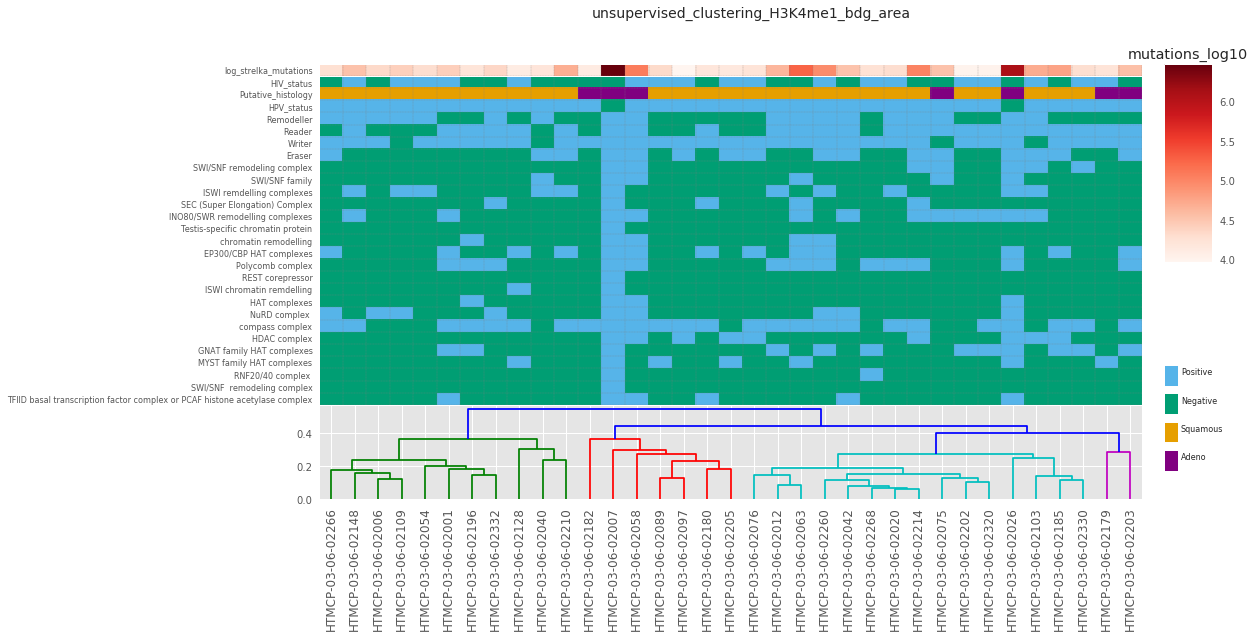

merging signal for mark: H3K4me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.06 s, sys: 3.04 s, total: 6.1 s
Wall time: 7.89 s


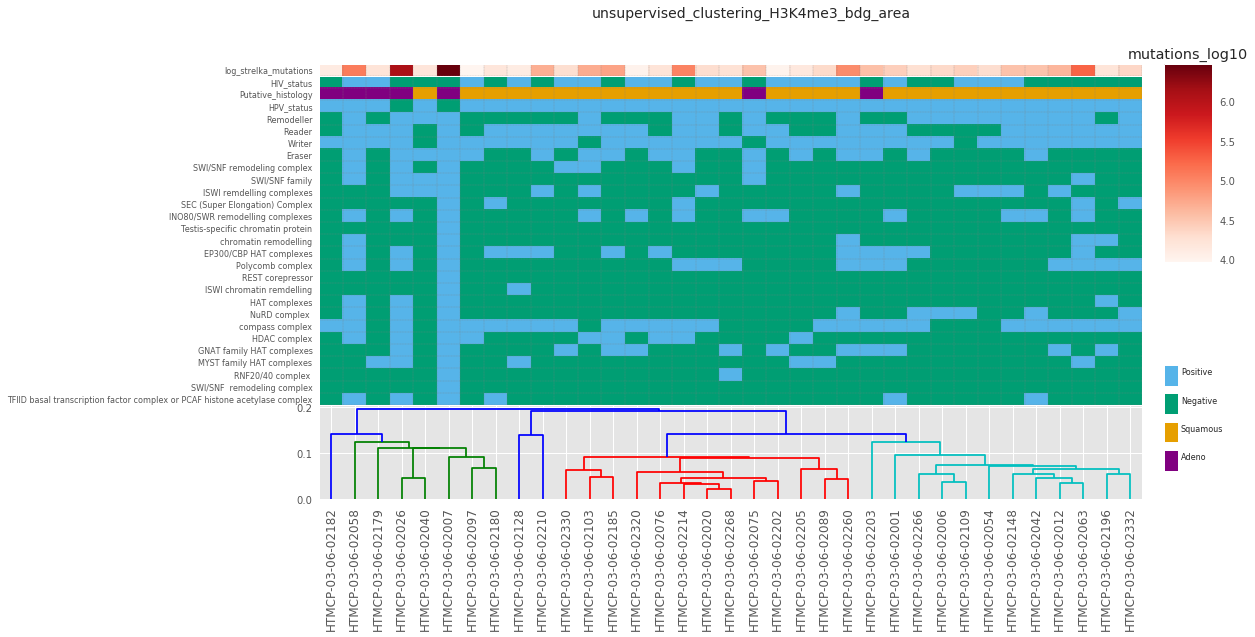

merging signal for mark: H3K9me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.14 s, sys: 2.62 s, total: 6.76 s
Wall time: 6.76 s


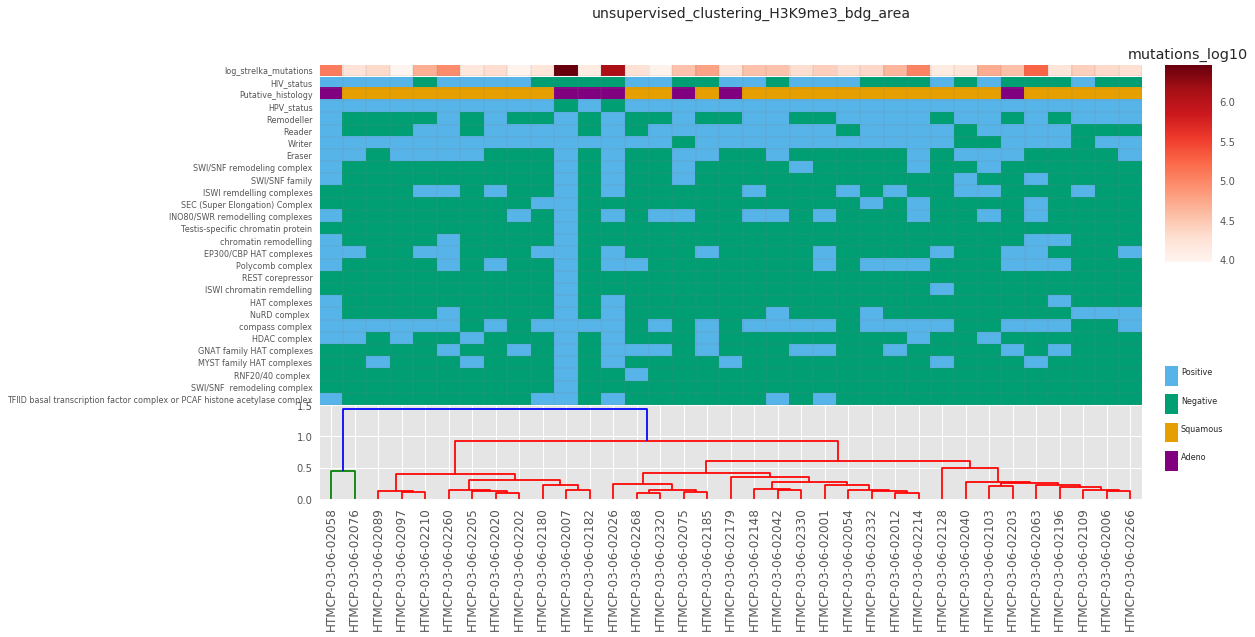

merging signal for mark: H3K27me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.17 s, sys: 12.3 s, total: 15.5 s
Wall time: 29.1 s


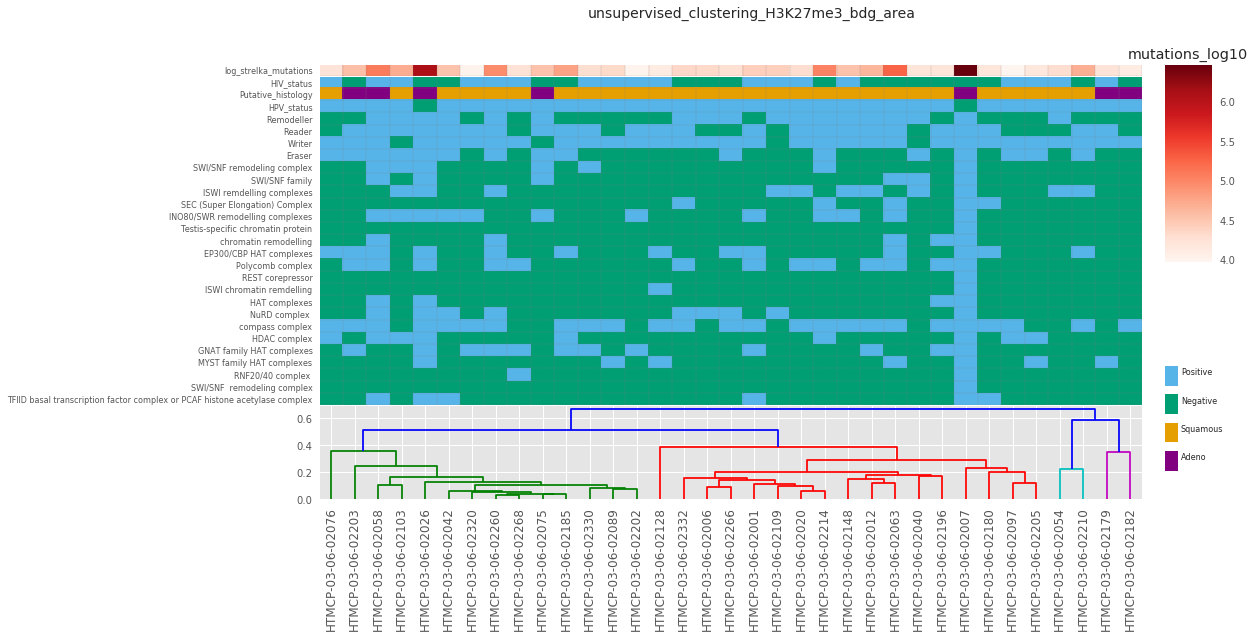

merging signal for mark: H3K36me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.61 s, sys: 3.99 s, total: 8.6 s
Wall time: 8.74 s


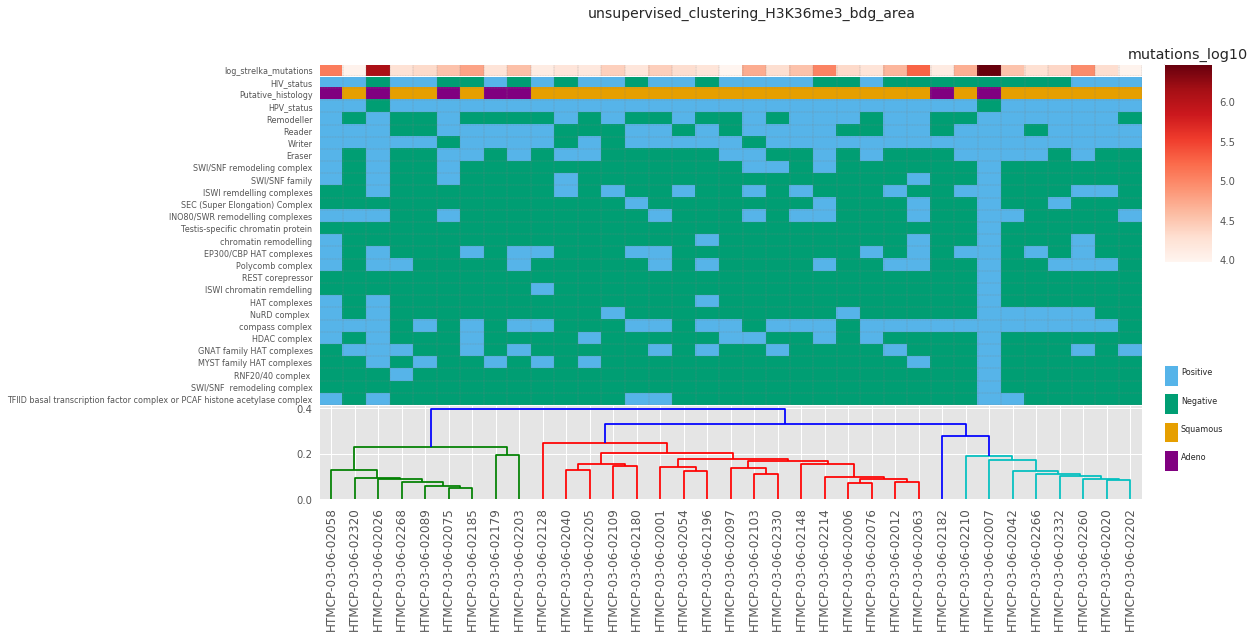

merging signal for mark: H3K27ac
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.68 s, sys: 7.94 s, total: 11.6 s
Wall time: 21.8 s


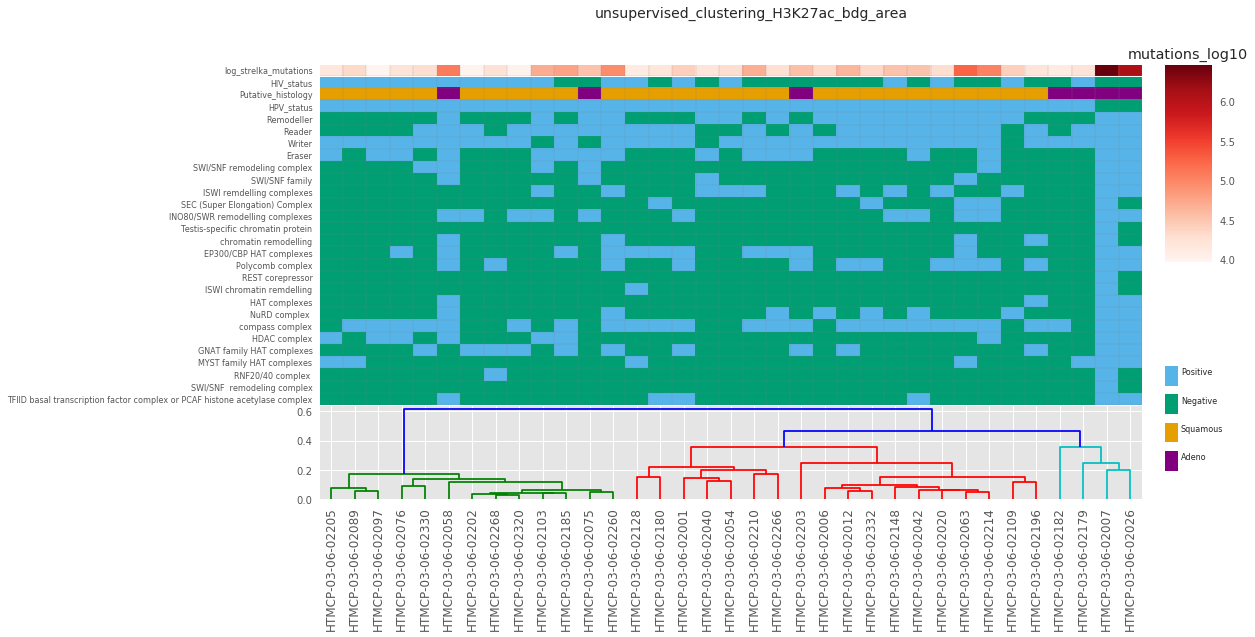

In [94]:
for mark in marks:
    print('merging signal for mark: {}'.format(mark))
    df_mark = df1[df1['file'].str.contains(mark)]
    dfm_mark = merge_data(df_mark)
    dfm_mark = dfm_mark/4000 # length of the promoter regaionx
    lib_name = '{} library ID'.format(mark)
    df_meta1 = df_meta[[lib_name, 'patient']].set_index(lib_name)
    d = df_meta1.to_dict()
    dfm_mark.columns = dfm_mark.columns.to_series().map(d['patient'])
    cat_track = category_track.set_index('patient')
    clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
    map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
    plot_cluster(numeric_track, ncategory_track, dfm_mark, mark, map_dict2)


In [96]:
dfm_mark.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02006  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            4.76600            1.86050   
     67092 71091 ENSG00000186092            2.35975            1.00375   

                                  HTMCP-03-06-02007  HTMCP-03-06-02012  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            1.43025              1.100   
     67092 71091 ENSG00000186092            1.53500              0.381   

                                  HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            2.93675            0.62200   
     67092 71091 ENSG00000186092            2.02000            0.30275   

                                  HTMCP-03-06-02040  HTMCP-03-06-02042  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            2.84000            2.66825   
     67092 71091 ENSG00000186092            1.16075            2.09950   

                                  HTMCP-03-06-02054  HTMCP-03-06-02058  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            4.26975            3.34125   
     67092 71091 ENSG00000186092            0.85525            0.20625   

                                        ...          HTMCP-03-06-02210  \
chr  start end   gene                   ...                              
chr1 34081 38080 ENSG00000237613        ...                    2.12025   
     67092 71091 ENSG00000186092        ...                    2.62850   

                                  HTMCP-03-06-02214  HTMCP-03-06-02202  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            1.65675           7.565425   
     67092 71091 ENSG00000186092            0.45250           0.657195   

                                  HTMCP-03-06-02182  HTMCP-03-06-02260  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613           3.427028            2.27375   
     67092 71091 ENSG00000186092           2.771102            1.25550   

                                  HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613           6.742949               2.04   
     67092 71091 ENSG00000186092           2.689243               0.28   

                                  HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613             1.1745             0.9500   
     67092 71091 ENSG00000186092             0.4050             0.4525   

                                  HTMCP-03-06-02332  
chr  start end   gene                                
chr1 34081 38080 ENSG00000237613           2.861793  
     67092 71091 ENSG00000186092           1.286153  

[2 rows x 35 columns]

In [100]:
matplotlib.is_interactive()

True

In [236]:
df32 = pd.DataFrame(df3.file_y)
dfm2 = merge_data(df32)
dfm2 = dfm2/4000 # length of the promoter regaion
dfm2.head()

A84611_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.427685   
     67092  71091  ENSG00000186092                0.061214   
     365641 369640 ENSG00000235249                0.041954   
     620053 624052 ENSG00000185097                0.043833   
     858261 862260 ENSG00000187634                0.559055   

                                    A84618_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.310419   
     67092  71091  ENSG00000186092                0.055682   
     365641 369640 ENSG00000235249                0.009753   
     620053 624052 ENSG00000185097                0.019739   
     858261 862260 ENSG00000187634                0.287142   

                                    A84625_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.252474   
     67092  71091  ENSG00000186092                0.113265   
     365641 369640 ENSG00000235249                0.007909   
     620053 624052 ENSG00000185097                0.003780   
     858261 862260 ENSG00000187634                0.111270   

                                    A84632_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.204968   
     67092  71091  ENSG00000186092                0.049366   
     365641 369640 ENSG00000235249                0.034107   
     620053 624052 ENSG00000185097                0.044374   
     858261 862260 ENSG00000187634                0.226632   

                                    A84639_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.228736   
     67092  71091  ENSG00000186092                0.203678   
     365641 369640 ENSG00000235249                0.041958   
     620053 624052 ENSG00000185097                0.027462   
     858261 862260 ENSG00000187634                0.014630   

                                    A84646_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.146941   
     67092  71091  ENSG00000186092                0.133603   
     365641 369640 ENSG00000235249                0.016568   
     620053 624052 ENSG00000185097                0.020352   
     858261 862260 ENSG00000187634                0.094569   

                                    A84653_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.130224   
     67092  71091  ENSG00000186092                0.105407   
     365641 369640 ENSG00000235249                0.022140   
     620053 624052 ENSG00000185097                0.058604   
     858261 862260 ENSG00000187634                0.020124   

                                    A84660_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.237918   
     67092  71091  ENSG00000186092                0.316299   
     365641 369640 ENSG00000235249                0.013750   
     620053 624052 ENSG00000185097                0.044327   
     858261 862260 ENSG00000187634                0.032539   

                                    A84667_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.352411   
     67092  71091  ENSG00000186092                0.073475   
     365641 369640 ENSG00000235249                0.018340   
     620053 624052 ENSG00000185097                0.017215   
     858261 862260 ENSG00000187634                0.262516   

                                    A84674_H3K4me3_control  \
chr  start  end    gene                                    

# make input file for ChromHMM

In [2]:
f = '/home/szong/projects/META_2018/Master_Sample_table_14X292_Feb27_2018_sz.xls'
meta = pd.read_excel(f, sheetname='HTMCP CaCx epi')
meta.head(2)

,Order,Biospecimen ID,HIV status,Epigenome modifier mutation status,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,...,H3K4me3 % aligned,H3K9me3 % aligned,H3K27me3 % aligned,H3K36me3 % aligned,H3K27ac % aligned,input DNA control % aligned,internal sample ID,pool ID,Notes,# lanes 7 PE
0,1,HTMCP-03-06-02007-01A,negative,mutated,A84624,A84625,A84626,A84627,A84628,A84629,...,98.13,93.1,97.93,98.57,98.10,96.26,NaN,IX5978,NaN,1
1,2,HTMCP-03-06-02026-01A,negative,mutated,A84645,A84646,A84647,A84648,A84649,A84650,...,97.68,93.89,97.84,98.17,97.86,95.56,NaN,IX5981,NaN,1


In [3]:
meta.columns

Index(['Order', 'Biospecimen ID', 'HIV status',
       'Epigenome modifier mutation status', 'H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID',
       'input DNA control  library ID', ' Library construction status',
       'Sequencing status', 'H3K4me1 total reads', 'H3K4me3  total reads',
       'H3K9me3 total reads', 'H3K27me3 total reads', 'H3K36me3 total reads',
       'H3K27ac total reads', 'input DNA control  total reads',
       'H3K4me1 % aligned', 'H3K4me3  % aligned', 'H3K9me3 % aligned',
       'H3K27me3 % aligned', 'H3K36me3 % aligned', 'H3K27ac % aligned',
       'input DNA control   % aligned', 'internal sample ID', 'pool ID',
       'Notes', '# lanes 7 PE'],
      dtype='object')

In [4]:
meta.set_index('Biospecimen ID', inplace=True)

In [5]:
df = meta[['H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID', 'input DNA control  library ID']].stack().reset_index()

In [6]:
df.head(2)

,Biospecimen ID,level_1,0
0,HTMCP-03-06-02007-01A,H3K4me1 library ID,A84624
1,HTMCP-03-06-02007-01A,H3K4me3 library ID,A84625


In [7]:
df['marks'] = df.level_1.apply(lambda x: x.replace(' library ID', ''))
df['patient'] = df['Biospecimen ID'].apply(lambda x: x.replace('-01A', ''))
df.drop('Biospecimen ID', axis=1, inplace=True)

In [8]:
df = df.drop('level_1', axis=1)

In [9]:
df.head(2)

,0,marks,patient
0,A84624,H3K4me1,HTMCP-03-06-02007
1,A84625,H3K4me3,HTMCP-03-06-02007


In [100]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/libs.txt'
# df.to_csv(f, sep='\t', index=False, header=False)

In [81]:
df['treat'] = 'sorted_UCSC_' + df[0] + '_' + df['marks'] + '_treat_pileup.bdg'

In [82]:
df['control'] = 'sorted_UCSC_' + df[0] + '_' + df['marks'] + '_control_lambda.bdg'

In [83]:
df.head(2)

,0,marks,patient,treat,control
0,A84624,H3K4me1,HTMCP-03-06-02007,sorted_UCSC_A84624_H3K4me1_treat_pileup.bdg,sorted_UCSC_A84624_H3K4me1_control_lambda.bdg
1,A84625,H3K4me3,HTMCP-03-06-02007,sorted_UCSC_A84625_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84625_H3K4me3_control_lambda.bdg


In [84]:
df = df.drop(0, axis=1)

In [85]:
df.head(2)

,marks,patient,treat,control
0,H3K4me1,HTMCP-03-06-02007,sorted_UCSC_A84624_H3K4me1_treat_pileup.bdg,sorted_UCSC_A84624_H3K4me1_control_lambda.bdg
1,H3K4me3,HTMCP-03-06-02007,sorted_UCSC_A84625_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84625_H3K4me3_control_lambda.bdg


In [87]:
cols = ['patient', 'marks', 'treat', 'control']

In [89]:
df = df[cols]

In [90]:
# f = '/projects/da_workspace/software/ChromHMM/Cervical/bed_files.txt'
# df.to_csv(f, sep='\t', index=False, header=False)

In [11]:
df1 = df.set_index(0)

In [12]:
df1.head(2)

,marks,patient
0,,
A84624,H3K4me1,HTMCP-03-06-02007
A84625,H3K4me3,HTMCP-03-06-02007


In [13]:
# fbam = '/projects/da_workspace/software/ChromHMM/Cervical/bam_files.txt'
fbam = '/projects/da_workspace/software/ChromHMM/Cervical/bam_path_from_victoira.txt'
dfbam = pd.read_csv(fbam, sep='\t', header=None, index_col=0)
dfbam.head(2)

,1
0,
A84610,/projects/analysis/analysis30/IX5976/CC0TLANXX...
A84611,/projects/analysis/analysis30/IX5976/CC0TLANXX...


In [14]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/bam_files.txt'
dfm = pd.merge(df1, dfbam, left_index=True, right_index=True).set_index('patient', drop=True)
# dfm.to_csv(f, sep='\t', header=False)

In [17]:
dfm.marks.unique()

array(['H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K27ac',
       'input DNA control '], dtype=object)

In [21]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/control_bam_files.txt'
dfm[dfm.marks == 'input DNA control '].to_csv(f, sep='\t', header=False)

In [24]:
dfm[dfm[1].isnull()]

,marks,1
patient,,


# look at acetylation level between HDAC mutants and wild type, H3K27ac unsupervised clustering groups

In [162]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/'

In [163]:
f1 = '{}H3K27ac_promoter_area_files.txt'.format(wkdir)
df1 = pd.read_csv(f1, header=None)
df1.head(2)

,0
0,sorted_UCSC_A84615_H3K27ac_treat_pileup.bdg.in...
1,sorted_UCSC_A84622_H3K27ac_treat_pileup.bdg.in...


In [164]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/category_track.txt'
df2 = pd.read_csv(f2)
df2.head(2)

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


In [165]:

dfm = pd.DataFrame()
for idx, f in df1.iterrows():
    f1 = '{0}{1}'.format(wkdir, f[0])
#     print(f1)
#         library = '_'.join(f['file_y'].split('_')[2:5])
    library = f1.split('_')[4]
#     print(library)
    dftmp = pd.read_csv(f1).set_index(['chr', 'start', 'end', 'gene'])
    dftmp.columns = [library]
#     break
    if dfm.empty:
        dfm = dftmp.copy()
    else:
        dfm = pd.merge(dfm, dftmp, left_index=True, right_index=True)


In [166]:
dfm.head(2)

A84615  A84622  A84629  A84636   A84643  \
chr  start end   gene                                                        
chr1 34081 38080 ENSG00000237613  19064.0  7442.0  5721.0  4400.0  11747.0   
     67092 71091 ENSG00000186092   9439.0  4015.0  6140.0  1524.0   8080.0   

                                  A84650   A84657   A84664   A84671   A84678  \
chr  start end   gene                                                          
chr1 34081 38080 ENSG00000237613  2488.0  11360.0  10673.0  17079.0  13365.0   
     67092 71091 ENSG00000186092  1211.0   4643.0   8398.0   3421.0    825.0   

                                     ...        A84790  A84797       A84804  \
chr  start end   gene                ...                                      
chr1 34081 38080 ENSG00000237613     ...        8481.0  6627.0  30261.70029   
     67092 71091 ENSG00000186092     ...       10514.0  1810.0   2628.77945   

                                       A84811  A84825       A84832  A84839  \
chr  start end   gene                                                        
chr1 34081 38080 ENSG00000237613  13708.11210  9095.0  26971.79655  8160.0   
     67092 71091 ENSG00000186092  11084.40853  5022.0  10756.97227  1120.0   

                                  A84846  A84853       A84860  
chr  start end   gene                                          
chr1 34081 38080 ENSG00000237613  4698.0  3800.0  11447.17304  
     67092 71091 ENSG00000186092  1620.0  1810.0   5144.61222  

[2 rows x 35 columns]

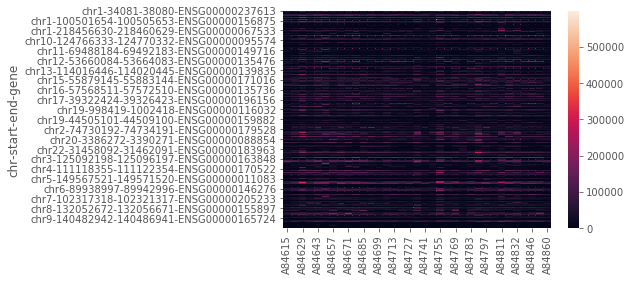

In [167]:
sns.heatmap(dfm)

In [168]:
df2[df2['HDAC complex'] == 'Positive'][['patient', 'HDAC complex', ]]

,patient,HDAC complex
0,HTMCP-03-06-02007,Positive
1,HTMCP-03-06-02026,Positive
3,HTMCP-03-06-02214,Positive
6,HTMCP-03-06-02185,Positive
17,HTMCP-03-06-02058,Positive
25,HTMCP-03-06-02097,Positive
29,HTMCP-03-06-02103,Positive
31,HTMCP-03-06-02205,Positive
34,HTMCP-03-06-02076,Positive


In [169]:
df3 = meta[['H3K27ac library ID', 'patient']].set_index('H3K27ac library ID')

In [170]:
df4 = pd.merge(dfm.mean().to_frame(), df3, left_index=True, right_index=True).reset_index()

In [171]:
df4.head(2)

,index,0,patient
0,A84615,28958.250262,HTMCP-03-06-02001
1,A84622,37955.755920,HTMCP-03-06-02006


In [172]:
df5 = pd.merge(df4, df2, left_on='patient', right_on='patient')

In [173]:
df5

,index,0,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,A84615,28958.250262,HTMCP-03-06-02001,Positive,Squamous,Positive,Negative,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Positive
1,A84622,37955.755920,HTMCP-03-06-02006,Negative,Squamous,Positive,Positive,Negative,Positive,Negative,...,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative
2,A84629,58174.432026,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
3,A84636,39213.776061,HTMCP-03-06-02012,Negative,Squamous,Positive,Positive,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Negative
4,A84643,52004.792612,HTMCP-03-06-02020,Positive,Squamous,Positive,Positive,Positive,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative
5,A84650,50371.768483,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive
6,A84657,44689.170597,HTMCP-03-06-02040,Negative,Squamous,Positive,Positive,Negative,Negative,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
7,A84664,47187.691859,HTMCP-03-06-02042,Negative,Squamous,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative,Positive
8,A84671,45415.652076,HTMCP-03-06-02054,Positive,Squamous,Positive,Positive,Negative,Positive,Negative,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
9,A84678,46467.788773,HTMCP-03-06-02058,Positive,Adeno,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Negative,Negative,Negative,Negative,Positive


In [174]:
labels = df5.columns.tolist()
labels[0] = 'library'
labels[1] = 'area'
labels

['library',
 'area',
 'patient',
 'HIV_status',
 'Putative_histology',
 'HPV_status',
 'Remodeller',
 'Reader',
 'Writer',
 'Eraser',
 'SWI/SNF remodeling complex',
 'SWI/SNF family',
 'ISWI remdelling complexes',
 'SEC (Super Elongation) Complex',
 'INO80/SWR remodelling complexes',
 'Testis-specific chromatin protein',
 'chromatin remodelling',
 'EP300/CBP HAT complexes',
 'Polycomb complex',
 'REST corepressor',
 'ISWI chromatin remdelling',
 'HAT complexes',
 'NuRD complex\xa0',
 'compass complex',
 'HDAC complex',
 'GNAT family HAT complexes',
 'MYST family HAT complexes',
 'RNF20/40 complex\xa0',
 'SWI/SNF  remodeling complex',
 'TFIID basal transcription factor complex or PCAF histone acetylase complex']

In [175]:
df5.columns = labels

In [176]:
f5 = '{}category_track_wit_libid.txt'.format(wkdir)
# df5.to_csv(f5, index=False)

In [177]:
df6 = df5[['patient', 'area', 'HDAC complex']]

observation: no difference in terms of acetylation level, the top 2 HDAC dots are 2007/2026 hypermutated cases. make sense since we have >10 genes in HDAC super family, HDAC1 and HADA2 are functionally redundant, so no patients are mutated in all these genes. parellel pathways

In [178]:
# df6

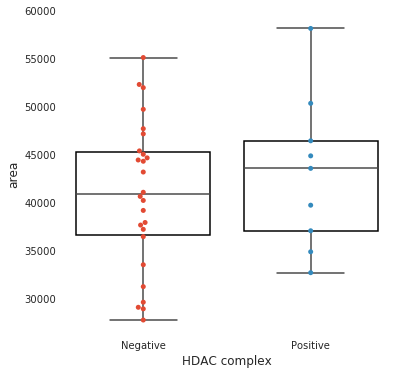

In [182]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='white', figsize=(6,6))
    ax = sns.boxplot('HDAC complex', 'area', data=df6)
    for mybox in ax.artists:
        mybox.set_facecolor('white')
        mybox.set_edgecolor('black')
#     mybox.set_linewidth(3)
    sns.swarmplot('HDAC complex', 'area', data=df6)
    sns.despine(bottom=True, left=True)
    plt.savefig('{}/HDAC_comparison.png'.format(wkdir), bbox_inches='tight', dpi=200)

In [180]:
df6.sort_values('area')

,patient,area,HDAC complex
19,HTMCP-03-06-02179,27794.368912,Negative
0,HTMCP-03-06-02001,28958.250262,Negative
18,HTMCP-03-06-02148,29120.059873,Negative
34,HTMCP-03-06-02332,29650.263705,Negative
23,HTMCP-03-06-02203,31272.001070,Negative
16,HTMCP-03-06-02103,32726.395085,Positive
12,HTMCP-03-06-02075,33552.819831,Negative
15,HTMCP-03-06-02097,34904.820280,Positive
31,HTMCP-03-06-02268,36480.872925,Negative
21,HTMCP-03-06-02185,37092.665736,Positive
